<a href="https://colab.research.google.com/github/Ivan-Dyncan/ImageComparison/blob/main/%D0%9D%D0%B0%D1%85%D0%BE%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BE%D1%82%D0%BB%D0%B8%D1%87%D0%B8%D0%B9_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Можно скачать картинки отсюда https://drive.google.com/drive/folders/1AOQSb3hiTspT07b2o164BudZIOhWVBYM?usp=sharing

In [80]:
import cv2
from skimage.metrics import structural_similarity as ssim
import imutils
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops

In [207]:
class Images_comparison:
  def __init__(self, pathA, pathB):
    self.pathA=pathA #пути к картинкам
    self.pathB=pathB
    self.masks = 0

  # метрика SSIM  
  def find_SSIM(self):
    imageA = cv2.imread(self.pathA)
    imageB = cv2.imread(self.pathB)
    ch = 2 if len(imageA.shape)==3 else None
    (score, diff) = ssim(imageA, imageB, full=True, channel_axis=ch)
    return score

  # возвращает две маски, сходств и различий, по умолчанию используется медианный
  # фильтр с kernel_size=3, чтобы убрать шум, можете отключить его
  # treshold - порог, ниже которого пиксели принимаются за схожие на основании их
  # разности. Применим в случае, когда не нужно учитывать яркость
  def binary_masks(self, use_m_filt=True, kernel_size=3, treshold=5):
    img1 = Image.open(self.pathA)
    img2 = Image.open(self.pathB)
    diff = np.array(ImageChops.difference(img1, img2))
    img =cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    if use_m_filt:
      #median_filter(img,kernel_size)
      img = cv2.medianBlur(img, kernel_size)
    similarity = np.vectorize(lambda x:True if x<=treshold else False)(img)
    difference = np.vectorize(lambda x:True if x> treshold else False)(img)
    self.masks = (similarity,difference)
    return similarity, difference

  # возвращает процент вхождений True в маску сходств
  # если маска раньше не нходилась, он найдет ее с дефолтными параметрами
  def bin_mask_fullness(self):
    if type(self.masks) == type(0):
      self.binary_masks()
    h,w = self.masks[0].shape
    count_of_true = self.masks[0].sum().sum()
    return count_of_true/(h*w)

(429, 750)

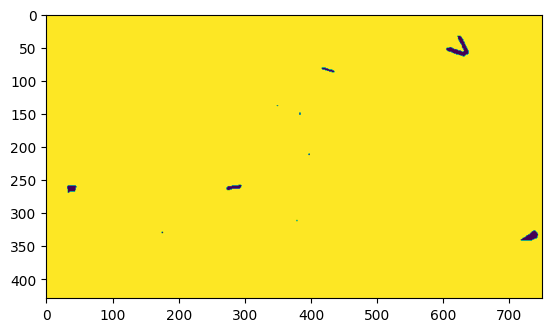

In [213]:
w1 = '/content/1.jpg'
w2 = '/content/2.jpg'
#w1 = '/content/sample0_0.jpg'
#w2 = '/content/sample1_1.jpg'
comp = Images_comparison(w1, w2)

m = comp.binary_masks(use_m_filt=True)

plt.imshow(m[0])
m[0].shape

In [209]:
comp.find_SSIM(), comp.bin_mask_fullness()

(0.9923624536877022, 0.9972556332556333)

#Дальше идут тесты кода, их можно не смотреть

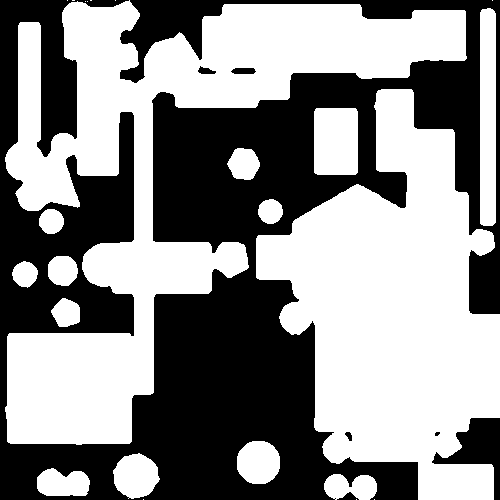

In [148]:
w1 = '/content/sample0_0.jpg'
w2 = '/content/sample1_1.jpg'
def median_filter(img, k):
  for i in range(k, len(img)-k):
    for j in range(k, len(img[0])-k):
      img[i][j]=np.median(img[i-k:i+k+1,j-k:j+k+1].reshape(-1))

img1 = Image.open(w1)
img2 = Image.open(w2)
diff = np.array(ImageChops.difference(img1, img2))
img =cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
median_filter(img,2)
c = np.vectorize(lambda x:0 if x<=5 else 255)(img)

cv2_imshow(c)

In [154]:
# load the two input images
imageA = cv2.imread('/content/sample0_0.jpg')
imageB = cv2.imread('/content/sample1_1.jpg')
# convert the images to grayscale


(score, diff) = ssim(imageA, imageB, full=True, channel_axis=2)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.3994673697674876


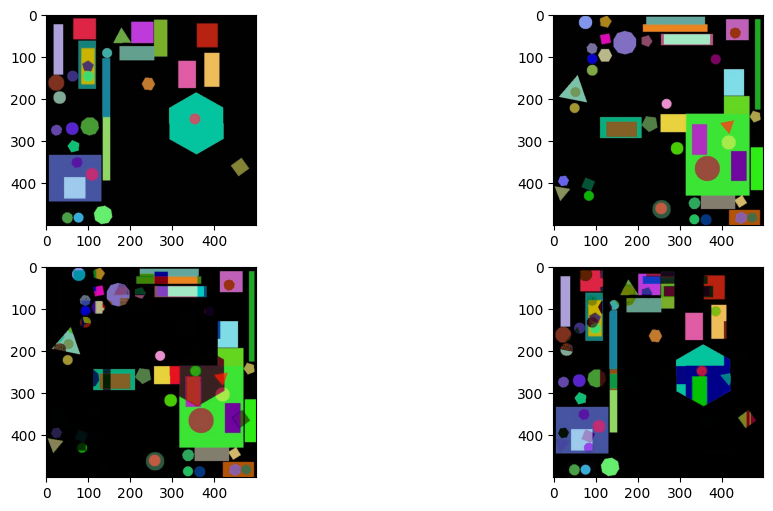

In [155]:
xor = cv2.bitwise_xor(imageA, imageB)
a_without_b = cv2.bitwise_and(xor, imageB)
b_without_a = cv2.bitwise_and(xor, imageA)

fig, axes = plt.subplots(2, 2)
axes[0][0].imshow(imageA.astype('uint8'))
axes[0][1].imshow(imageB.astype('uint8'))
axes[1][0].imshow(a_without_b.astype('uint8'))
axes[1][1].imshow(b_without_a.astype('uint8'))
fig.set_figwidth(12)  
fig.set_figheight(6)
plt.show()

In [ ]:
thresh = cv2.threshold(diff, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

error: ignored

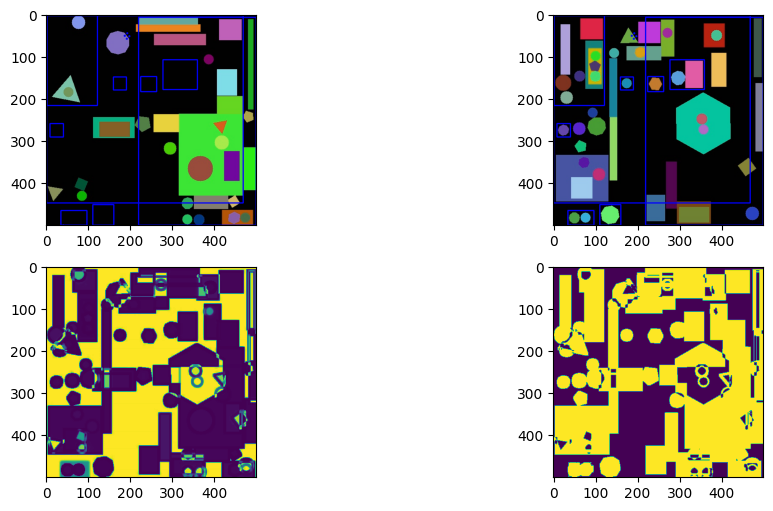

In [ ]:
for c in cnts:
	# compute the bounding box of the contour and then draw the
	# bounding box on both input images to represent where the two
	# images differ
	(x, y, w, h) = cv2.boundingRect(c)
	cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
	cv2.rectangle(imageB, (x, y), (x + w, y + h), (0, 0, 255), 2)
# show the output images

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)

axes[0][0].imshow(imageA.astype('uint8'))
axes[0][1].imshow(imageB.astype('uint8'))
axes[1][0].imshow(diff.astype('uint8'))
axes[1][1].imshow(thresh.astype('uint8'))
fig.set_figwidth(12)  
fig.set_figheight(6)
plt.show()
